<a href="https://colab.research.google.com/github/subodha1980/BU/blob/master/Assignment_PSO_with_Reroute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add the relavent libraries

In [3]:
import numpy as np
from numpy.random import rand
from numpy.random import choice
import math
import matplotlib.pyplot as plt
from operator import itemgetter
import random

import pandas as pd
import csv
import copy


Utility functions to access vehicle information

In [12]:
V_INDEX = 0
X_INDEX = 1
Y_INDEX = 2

B1 = [-1   ,-1]
B2 = [56325, 9]
BS_LOC = [B1,B2]

link_rates = [10,8,6,4,2,1,0]
dist_bins = [500,1000,2000,3000,4000,6000,999999]

def get_data_rate(dist):  return link_rates[(np.digitize(dist,dist_bins))] #bin_id = np.digitize(dist,dist_bins)

def get_distance(p1,p2): return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def get_zero_List(k): return [[0 for col in range(k)] for row in range(k)]


Read location file

In [13]:
file_name = '/content/drive/MyDrive/Colab Notebooks/Assignment/data_file.csv' # you can mount a file in the google drive and copy the path too

def read_file():
  with open(file_name, 'rt') as f:
      csv_reader = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC) # reading values as values (not strings)
      vehicle_data = []
      for line in csv_reader:
        vehicle_data.append([int(line[V_INDEX]),line[X_INDEX],line[Y_INDEX]])
  return vehicle_data

neighbors = []                          # contains list of neighbors for every node
vehicles = read_file()                  # contains the vehicle ID and positions
rates = get_zero_List(len(vehicles)+2)  # contains the rates of each hop, (+2) for two BSs
distances = get_zero_List(len(vehicles)+2)
NO_OF_CARS = len(vehicles)
BS1_ID = NO_OF_CARS + 1   # ID of BS 1
BS2_ID = BS1_ID + 1       # ID of BS 2
vehicles.append([BS1_ID, -1, -1])
vehicles.append([BS2_ID, 56325, 9])

ONE_HOP_LATENCY = 50

Initialize the neighboring cars for each car

In [14]:
def get_neighbors():
      for line in vehicles:
        neighbor_line = []
        P_new = [line[X_INDEX],line[Y_INDEX]] #select one vehicle

        for car in vehicles:
            if (line[V_INDEX]!=car[V_INDEX]): # itself cannot be a neighbour
                Q_new = [car[X_INDEX],car[Y_INDEX]] # select neighbor vehicle
                distance = get_distance(Q_new,P_new)
                rate = get_data_rate(distance) # get the rate based on the distance
                if (rate>0): neighbor_line.append(car[V_INDEX])
                rates[line[V_INDEX]-1][car[V_INDEX]-1] = rate
                distances[line[V_INDEX]-1][car[V_INDEX]-1] = distance
        #print(line[V_INDEX],':',neighbor_line)
        neighbors.append(neighbor_line)

def print_neighbors():
  for i, sublist in enumerate(neighbors, 1):
      print(f"Car {i}: {sublist}")

def print_rates():
  for i, sublist in enumerate(rates, 1):
      print(f"Car {i}: {sublist}")

get_neighbors()
#print_neighbors()
#print_rates()


In [23]:
#P shouldn't contain any element from current path
def get_next_car_1(P):
    # can select the BS with higher probability
    if BS1_ID in P and BS2_ID in P:
        if rand()>0.9:
          if rand()>0.5: return BS1_ID
          else: return BS2_ID
    elif BS1_ID in P:
        if rand()>0.9: return BS1_ID
    elif BS2_ID in P:
        if rand()>0.9: return BS2_ID
    # when a BS is not selected
    next_car = random.choice(P)
    return next_car

def get_next_car(P,path_rate,from_car):
    # can select the BS if rate to BS is higher than rath rate
    if BS1_ID in P and BS2_ID in P:
        if rates[from_car-1][BS1_ID-1]>=path_rate:
          path_rate = rates[from_car-1][BS1_ID-1]
          next_car = BS1_ID
        if rates[from_car-1][BS2_ID-1]>=path_rate:
          next_car = BS2_ID
        return next_car
    elif BS1_ID in P:
        if rates[from_car-1][BS1_ID-1]>=path_rate: return BS1_ID
    elif BS2_ID in P:
        if rates[from_car-1][BS2_ID-1]>=path_rate: return BS2_ID
    # when a BS is not selected
    next_car = random.choice(P)
    return next_car

def get_path(start_car,this_path):

    while (len(this_path)<NO_OF_CARS):
        #get the list of neighbours
        P = (neighbors[start_car-1]).copy()
        #remove elements in this_path from P
        P = [element for element in P if element not in this_path]
        if not P: return False

        this_path.append(start_car)

        #next_car = get_next_car_1(P)
        next_car = get_next_car(P,get_path_rate(this_path),start_car)
        if next_car == BS1_ID or next_car == BS2_ID:
          this_path.append(next_car)
          return True

        #RETRY_LIMIT = 10
        #next_car cannot be in this_path as its selected from P and P does not
        #have anything in common with this_path
        #retry = 0
        #while next_car in this_path:
        #    next_car = get_next_car(P)
        #    retry += 1
        #    if retry > RETRY_LIMIT:
        #        print('Retry:',retry)
        #        return False

        start_car = next_car

    else: return False

def reroute(this_path):
    new_path = []
    if len(this_path) < 2: print("1. Path length less than 2:",this_path)
        #return this_path
    elif len(this_path) == 2:
        if (get_path(this_path[0],new_path)==True): this_path = new_path.copy()
            #return this_path
        #else: return  this_path
    else:
        random_index = random.randint(1, len(this_path) - 2)
        # Copy elements from the first element to the randomly selected index to new_path
        new_path = this_path[:random_index]
        start_car = this_path[random_index]
        if (get_path(start_car,new_path) == True): this_path = new_path.copy()
            #return new_path
        #else: return this_path
    return this_path

def reroute_to_another_path(this_path,other_path):
    if len(this_path) < 2 or len(other_path)<2 : print("2. Path length less than 2:",this_path, other_path)
        #return this_path
    elif (len(other_path) == 2) or (len(this_path) == 2): this_path = other_path.copy()
        #return this_path
    else:
        #Common element in two paths
        common_elements = set(this_path[1:-1]).intersection(set(other_path[1:-1]))
        # If common elements exist
        if common_elements:
          # First common element in this_path
          first_common_element = this_path[next(i for i, el in enumerate(this_path) if el in common_elements)]

          # Generate new re-routed path
          new_path = this_path[:this_path.index(first_common_element) + 1]

          # Append elements appearing after the common element in other_path to new_path
          new_path.extend(other_path[other_path.index(first_common_element) + 1:])

          this_path = new_path.copy()
    return this_path

def get_path_rate(this_path):
    if len(this_path)<2: return 0
    link_rates = []
    for i in range(1, len(this_path)):
        link_rates.append(rates[this_path[i-1]-1][this_path[i]-1])
    return min(link_rates)

ALPHA, BETA, GAMMA = 0, 1, 0
def fitness(this_path):
    return ALPHA * (1/this_path.length) + BETA * this_path.rate/(1+ GAMMA * this_path.length)

def get_best_path(path1,path2):
    if (path1.rate >= path2.rate) and (path1.length <= path2.length): return path1
    if (path1.rate <= path2.rate) and (path1.length >= path2.length): return path2

    if (fitness(path1) == fitness(path2)):
       if (path1.rate>=path2.rate): return path1
       else: return path2
    elif (fitness(path1) > fitness(path2)): return path1
    else: return path2

#get_next_car([20,30,102,101])
my_path1 = []
my_path2 = []
get_path(2,my_path1)
get_path(2,my_path2)
print('1:',my_path1)
print('2:',my_path2)
A = reroute(my_path1)
print('RR:',A, my_path1)
B = reroute_to_another_path(my_path1,my_path2)
print('RB:',B, my_path1)

get_path_rate([58, 55, 9, 17, 18, 20, 19, 14, 60, 13, 7, 53, 6, 12, 5, 3, 57, 59, 21, 64, 62, 16, 61, 63, 23, 67, 72, 74, 28, 66, 68, 73, 30, 70, 71, 65, 25, 26, 29, 76, 35, 38, 42, 46, 50, 94, 100, 93, 48, 98, 99, 97, 95, 91, 88, 45, 90, 85, 89, 41, 44, 49, 92, 87, 84, 37, 80, 39, 43, 47, 86, 83, 82, 36, 32, 31, 77, 33, 75, 79, 40, 81, 34, 58, 10, 15, 8, 11, 54, 101])

1: [2, 101]
2: [2, 101]
RR: [2, 101] [2, 101]
RB: [2, 101] [2, 101]


0

In [24]:
class Path:
    def __init__(self, traversed_path):
        self.traversed_path = traversed_path.copy()
        self.length = len(self.traversed_path)-1
        self.latency = ONE_HOP_LATENCY * (len(self.traversed_path)-1)
        self.rate = get_path_rate(self.traversed_path)

    def display_info(self):
        print(f"Traversed Path: {self.traversed_path}")
        print(f"Length: {self.length}")
        print(f"Latency: {self.latency}")
        print(f"Rate: {self.rate}")

    def update(self):
        self.length = len(self.traversed_path)-1
        self.latency = ONE_HOP_LATENCY * (len(self.traversed_path)-1)
        self.rate = get_path_rate(self.traversed_path)

    def plot(self):
        x_list = []
        y_list = []
        for car in self.traversed_path:
            x_list.append(vehicles[car-1][X_INDEX])
            y_list.append(vehicles[car-1][Y_INDEX])

        fig, ax = plt.subplots()
        fig.suptitle('Path Using Particle Swarm Algorithm')

        # Plot the line with labels and ticks
        for i in range(len(x_list) - 1):
            plt.plot([x_list[i], x_list[i+1]], [y_list[i], y_list[i+1]], 'ro-')

            # Display the value obtained from the "rates" list on the line
            rate = rates[self.traversed_path[i] - 1][self.traversed_path[i+1] - 1]
            plt.text((x_list[i] + x_list[i+1]) / 2, (y_list[i] + y_list[i+1]) / 2, f'{rate}', color='blue')

            # Display "car" near each point
            if self.traversed_path[i] == BS1_ID: plt.text(x_list[i], y_list[i], f'BS1', color='green')
            elif self.traversed_path[i] == BS2_ID: plt.text(x_list[i], y_list[i], f'BS2', color='green')
            else: plt.text(x_list[i], y_list[i], f'Car-{self.traversed_path[i]}', color='green')

        # Display the last "car" near the last point
        if self.traversed_path[-1] == BS1_ID: plt.text(x_list[-1], y_list[-1], f'BS1', color='green')
        elif self.traversed_path[-1] == BS2_ID: plt.text(x_list[-1], y_list[-1], f'BS2', color='green')
        else: plt.text(x_list[-1], y_list[-1], f'Car-{self.traversed_path[-1]}', color='green')

        plt.show()


Traversed Path: [2, 5, 55, 3, 51, 101]
Length: 5
Latency: 250
Rate: 4


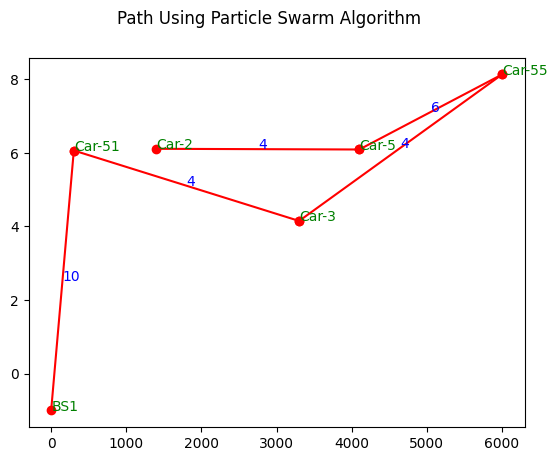

Traversed Path: [2, 5, 55, 3, 51, 101]
Length: 5
Latency: 250
Rate: 4


In [27]:
class Particle:
    def __init__(self, initial_path,id):
        self.id = id
        self.path = Path(initial_path)
        self.local_best_path = Path(initial_path)
        self.highest_rate_path = Path(initial_path)
        self.shortest_path = Path(initial_path)

    def update(self):
        self.path.update()

    def update_path(self):
        current_path = self.path.traversed_path.copy()
        g_best_path = pso.global_best_path.traversed_path.copy()
        l_best_path = self.local_best_path.traversed_path.copy()

        if rand() > pso.Ps: self.path.traversed_path = (reroute(current_path)).copy()
        else: self.path.traversed_path = (reroute_to_another_path(current_path,l_best_path)).copy()

        if rand() < pso.Pg: self.path.traversed_path = (reroute_to_another_path(current_path,g_best_path)).copy()

        self.update()

    def set_local_best(self):
        self.local_best_path = copy.deepcopy(get_best_path(self.local_best_path, self.path))

        # set highest rate path
        if self.highest_rate_path.rate < self.path.rate:
            self.highest_rate_path = copy.deepcopy(self.path)
        elif self.highest_rate_path.rate == self.path.rate:
            if self.highest_rate_path.length > self.path.length:
                self.highest_rate_path = copy.deepcopy(self.path)
        # set shortest path
        if self.shortest_path.length > self.path.length:
            self.shortest_path = copy.deepcopy(self.path)
        elif self.shortest_path.length == self.path.length:
             if self.shortest_path.rate < self.path.rate:
                 self.shortest_path = copy.deepcopy(self.path)

    def display_local_best_path(self):
            print('------Particle {}------'.format(self.id))
            self.local_best_path.display_info()
            print('------------------------')

    def reroute(self):
        new_path = []
        if self.path.length < 2: print("1. Path length less than 2:",self.path.traverse_path)
            #return this_path
        elif self.path.length == 2:
            if (get_path(self.path.traverse_path[0],new_path)==True): self.path.traverse_path = new_path.copy()
        else:
            random_index = random.randint(1, self.path.length - 2)
            # Copy elements from the first element to the randomly selected index to new_path
            new_path = self.path.traverse_path[:random_index]
            start_car = self.path.traverse_path[random_index]
            if (get_path(start_car,new_path) == True): self.path.traverse_path = new_path.copy()
            # if rerouting unsuccessful, do nothing
        self.path.update()

    def reroute_to_another_path(self,other_path):
        if self.path.length < 2 or len(other_path)<2 :
            print("2. Path length less than 2:",self.path.traverse_path, other_path)
        elif (len(other_path) == 2) or (self.path.length == 2):
            self.path.traverse_path = other_path.copy()
        else:
            #Common element in two paths
            common_elements = set(self.path.traverse_path[1:-1]).intersection(set(other_path[1:-1]))
            # If common elements exist
            if common_elements:
              # First common element in this_path
              first_common_element = self.path.traverse_path[next(i for i, el in enumerate(self.path.traverse_path) if el in common_elements)]

              # Generate new re-routed path
              new_path = self.path.traverse_path[:self.path.traverse_path.index(first_common_element) + 1]

              # Append elements appearing after the common element in other_path to new_path
              new_path.extend(other_path[other_path.index(first_common_element) + 1:])

              self.path.traverse_path = new_path.copy()
        self.path.update()

A = [2, 5, 55, 3, 51, 101]
path = Path(A)
path.display_info()
path.plot()
A[2] = 100
path.display_info()

-----Global Best------
Traversed Path: [25, 61, 17, 57, 4, 101]
Length: 5
Latency: 250
Rate: 1
Best Rate   : 1 | Latency: 250 | Traversed Path: [25, 61, 17, 57, 4, 101]
Best Latency: 250 | Rate: 1 | Traversed Path: [25, 61, 17, 57, 4, 101]
----------------------
-----Global Best------
Traversed Path: [25, 61, 17, 57, 4, 101]
Length: 5
Latency: 250
Rate: 1
Best Rate   : 1 | Latency: 250 | Traversed Path: [25, 61, 17, 57, 4, 101]
Best Latency: 250 | Rate: 1 | Traversed Path: [25, 61, 17, 57, 4, 101]
----------------------
-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 

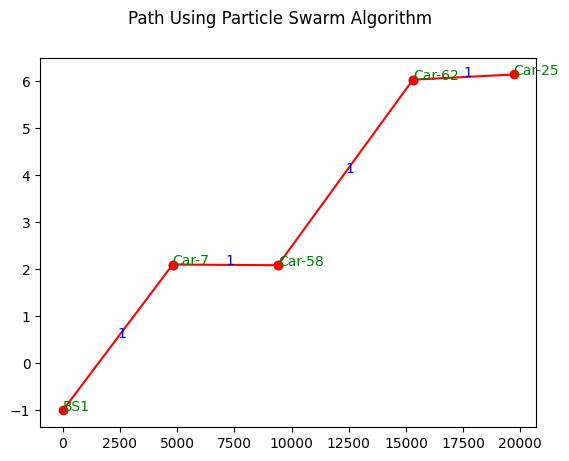

-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
-------------------

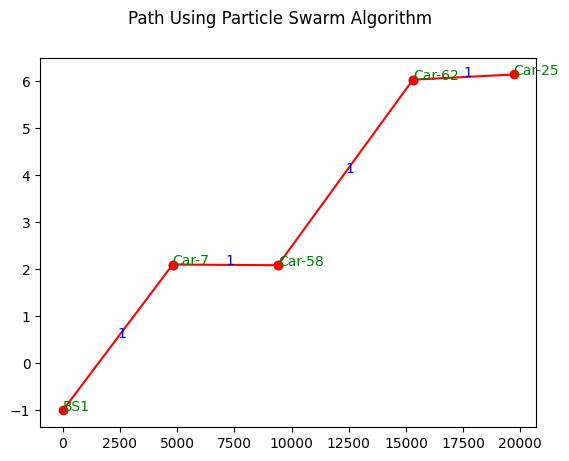

-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 62, 58, 7, 101]
Length: 4
Latency: 200
Rate: 1
Best Rate   : 1 | Latency: 200 | Traversed Path: [25, 62, 58, 7, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
-------------------

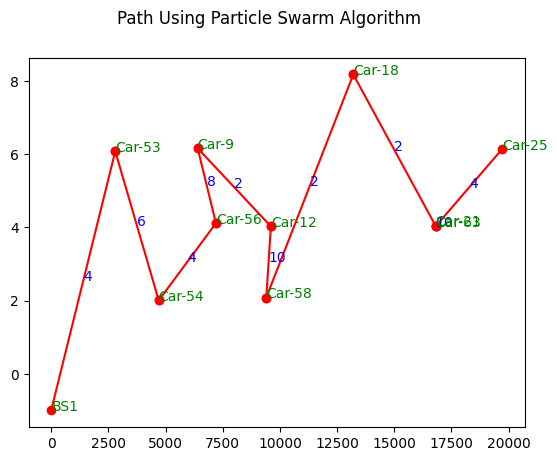

-----Global Best------
Traversed Path: [25, 63, 21, 18, 58, 12, 9, 56, 54, 53, 101]
Length: 10
Latency: 500
Rate: 2
Best Rate   : 2 | Latency: 500 | Traversed Path: [25, 63, 21, 18, 58, 12, 9, 56, 54, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 63, 21, 18, 58, 12, 9, 56, 54, 53, 101]
Length: 10
Latency: 500
Rate: 2
Best Rate   : 2 | Latency: 500 | Traversed Path: [25, 63, 21, 18, 58, 12, 9, 56, 54, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 63, 21, 18, 58, 12, 9, 56, 54, 53, 101]
Length: 10
Latency: 500
Rate: 2
Best Rate   : 2 | Latency: 500 | Traversed Path: [25, 63, 21, 18, 58, 12, 9, 56, 54, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 63, 21, 18, 58, 12, 9, 3, 101]
Length: 8
Latency: 400
Ra

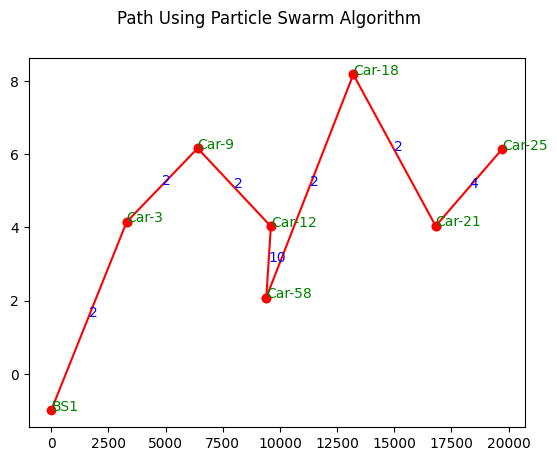

-----Global Best------
Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Length: 7
Latency: 350
Rate: 2
Best Rate   : 2 | Latency: 350 | Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Length: 7
Latency: 350
Rate: 2
Best Rate   : 2 | Latency: 350 | Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Length: 7
Latency: 350
Rate: 2
Best Rate   : 2 | Latency: 350 | Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Length: 7
Latency: 350
Rate: 2
Best Rate   : 2 | Latency: 350 | Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101

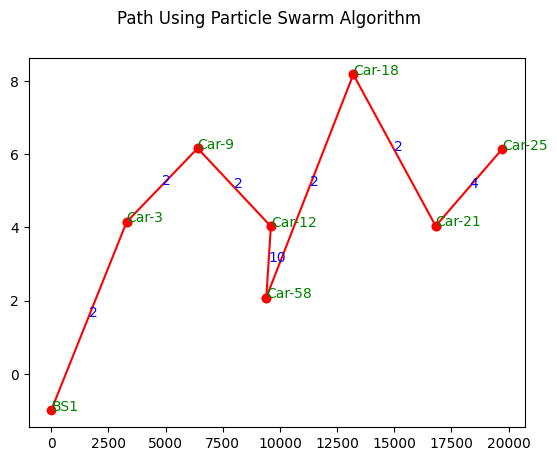

-----Global Best------
Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Length: 7
Latency: 350
Rate: 2
Best Rate   : 2 | Latency: 350 | Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Length: 7
Latency: 350
Rate: 2
Best Rate   : 2 | Latency: 350 | Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Length: 7
Latency: 350
Rate: 2
Best Rate   : 2 | Latency: 350 | Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101]
Length: 7
Latency: 350
Rate: 2
Best Rate   : 2 | Latency: 350 | Traversed Path: [25, 21, 18, 58, 12, 9, 3, 101

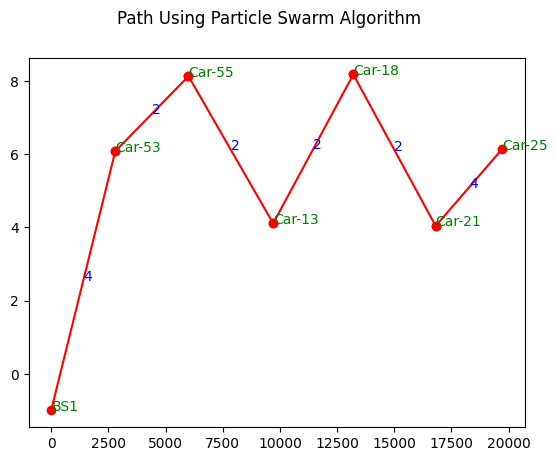

-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 

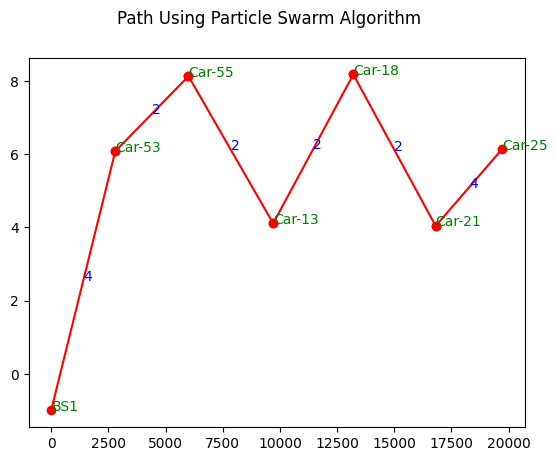

-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 

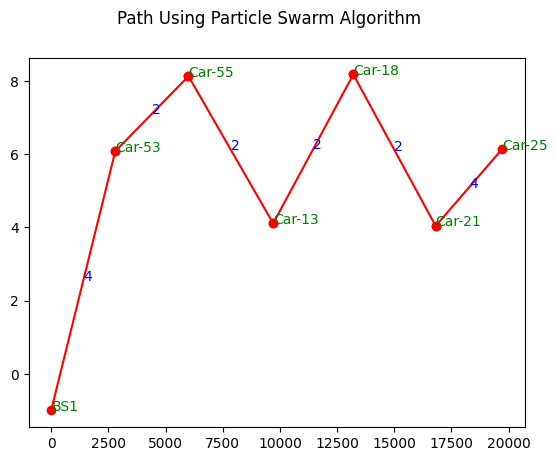

-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 

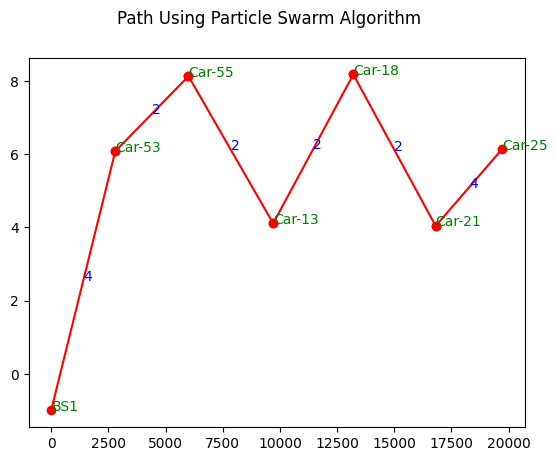

-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 200 | Rate: 1 | Traversed Path: [25, 62, 58, 7, 101]
----------------------
-----Global Best------
Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Length: 6
Latency: 300
Rate: 2
Best Rate   : 2 | Latency: 300 | Traversed Path: [25, 21, 18, 13, 55, 53, 101]
Best Latency: 

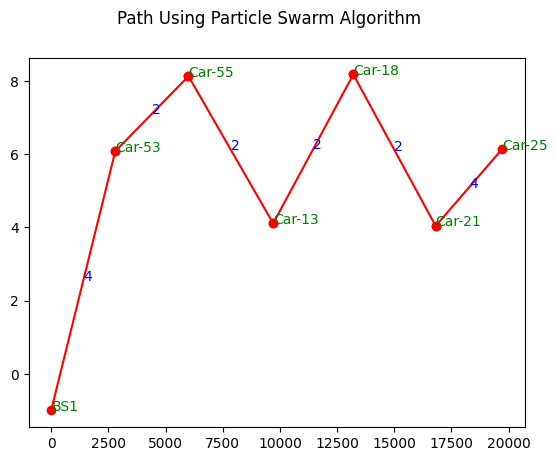

In [33]:
class PSO:
    def __init__(self,start_car, no_of_iterations):
        self.Ps = 0.4
        self.Pg = 0.15
        self.particles = []
        self.global_best_path = Path([1,102])
        self.highest_rate_path = Path([1,102])
        self.shortest_path = Path([1,102])
        self.no_of_samples = 100
        self.iterations = no_of_iterations
        self.initialize(start_car)

    def initialize(self,start_car):
        index = 1
        while (index<=self.no_of_samples):
            this_path = []
            from_car = start_car
            Success = get_path(from_car,this_path)
            while (Success==False):
              print("Retry Generating Path")
              this_path = []
              from_car = start_car
              Success = get_path(from_car,this_path)

            # Generate a particle and append to particles list
            self.particles.append(Particle(this_path,index))
            index += 1

    def display_particles(self):
          for particle in self.particles:
              print('---------{}-----------'.format(particle.id))
              particle.path.display_info()
              print('--------------------')

    def display_local_best_paths(self):
          for particle in self.particles:
              particle.display_local_best_path()

    def display_global_best_path(self):
          print('-----Global Best------')
          self.global_best_path.display_info()
          print(f"Best Rate   : {self.highest_rate_path.rate}",'|',f"Latency: {self.highest_rate_path.latency}",'|',f"Traversed Path: {self.highest_rate_path.traversed_path}")
          print(f"Best Latency: {self.shortest_path.latency}",'|',f"Rate: {self.shortest_path.rate}",'|',f"Traversed Path: {self.shortest_path.traversed_path}")
          print('----------------------')

    def update_particles(self):
          for particle in self.particles: particle.update_path()

    def set_global_best(self):
          for particle in self.particles:
              particle.set_local_best()
              if self.global_best_path.rate == 0:
                  self.global_best_path = copy.deepcopy(particle.local_best_path)
              else:
                  self.global_best_path = copy.deepcopy(get_best_path(self.global_best_path, particle.local_best_path))

              # set highest rate path
              if self.highest_rate_path.rate < particle.highest_rate_path.rate:
                  self.highest_rate_path = copy.deepcopy(particle.highest_rate_path)
              elif self.highest_rate_path.rate == particle.highest_rate_path.rate:
                  if self.highest_rate_path.length > particle.highest_rate_path.length:
                      self.highest_rate_path = copy.deepcopy(particle.highest_rate_path)

              # set shortest path
              if self.shortest_path.rate == 0:
                  self.shortest_path = copy.deepcopy(particle.shortest_path)
              else:
                  if self.shortest_path.length > particle.shortest_path.length:
                      self.shortest_path = copy.deepcopy(particle.shortest_path)
                  elif self.shortest_path.length == particle.shortest_path.length:
                      if self.shortest_path.rate < particle.shortest_path.rate:
                          self.shortest_path = copy.deepcopy(particle.shortest_path)

    def run(self):
        iteration = 1
        pso.set_global_best()
        pso.display_global_best_path()
        while iteration <= self.iterations:
            pso.update_particles()
            pso.set_global_best()
            pso.display_global_best_path()

            if iteration%10 == 0:
              pso.global_best_path.plot()

            iteration += 1


pso = PSO(25,100)
pso.run()

Path update function.As this is a discrete value optimization problem, the equation (3.3.1) cannot be directly applied. However, the effect of difference between particle best position and the global best position with the current particle position is captured by replacing the cars in the current path with the cars from best paths and the coefficients c1.r1 and c2.r2 are set to certain probabilities which can be fine tuned based on the requirement.
Comparison of two paths are carried out by comparing the car ID of each path position. However, this comparison is not straightforward as paths are of different lengths. In order to overcome this issue, paths are compared starting from the initial path position (car 9) until the length of the shorter of the two paths.

In addition to the path comparison, in order to better capture the influence of local and global best paths, we insert or delete elements from the current paths based on the same probabilities used for path comparison.

Finally, if the connected BS of the current path is different from the connected BS of the best path, it is updated to the base station of the best path.            

In order to avoid a new path being impacted by invalid particle best paths (invalid path is a path which gives a 0 rate), a fresh path is generated whenever both the particle best path and the new path are invalid.



In [ ]:
w = 0.5  # should be between 0 and 1
c1 = 1 # should be between 0 and 1
c2 = 1 # should be between 0 and 1
Pg = 0.15
Ps = 0.5
def update_path(current_path,g_best_path,s_best_path,v_t_1,car):
      new_path = current_path.copy()

      len_g = len(g_best_path)
      len_s = len(s_best_path)
      len_c = len(new_path)

      len_g_c = min(len_g,len_c)
      len_s_c = min(len_s,len_c)

      g_fitness = get_path_fitness(g_best_path)
      s_fitness = get_path_fitness(s_best_path)
      c_fitness = get_path_fitness(new_path)

      # When the best path is zero fitness
      if (s_fitness == 0 and c_fitness ==0):
          new_path = generate_a_sample()
          len_c = len(new_path)
          len_g_c, len_s_c = min(len_g,len_c), min(len_s,len_c)
          ## swap with its own elements
          #for i in range(1,1+int((len_c-2)/2)):
          #    if (rand()<Ps):
          #      temp = new_path[i]
          #      new_path[i] = new_path[len_c-2-i]
          #      new_path[len_c-2-i] = temp
          # Exchange the last car and BS
          if (BS_SELECT == 0):
              if (rand()<Ps):
                  #exchange_BSs(new_path,s_best_path)
                  switch_BS(new_path)
          if (new_path[len_c-2] != 2 and new_path[len_c-2] != 7): print(':',new_path)
      else:
          # swap with sample_best
          for i in range(1,len_s-2):
              # go from 1 to len_s-2
              if (i < len_s_c-2):
                if (rand()<Ps): # swap
                  if s_best_path[i] in new_path[0:len_c-2]:
                        new_index = new_path.index(s_best_path[i])
                        new_path[new_index] = new_path[i]
                  new_path[i] = s_best_path[i]

              # can write an else here fore rest of the elements in new path
          if (new_path[len_c-2] != 2 and new_path[len_c-2] != 7): print('2:',new_path)
      if (len_c > len_s):
          if (rand()<Ps): # remove element
              print(car,':sample:' , end='')
              remove_car_from_path(new_path,s_best_path)
              len_c = len(new_path)
              len_g_c, len_s_c = min(len_g,len_c), min(len_s,len_c)
          if (new_path[len_c-2] != 2 and new_path[len_c-2] != 7): print('3:',new_path)
      elif (len_c < len_s):
          if (rand()<Ps): # insert element
              print(car,':sample:' , end='')
              insert_car_to_path(new_path)
              len_c = len(new_path)
              len_g_c, len_s_c = min(len_g,len_c), min(len_s,len_c)
          if (new_path[len_c-2] != 2 and new_path[len_c-2] != 7): print('4:',new_path)

      # swap with global_best
      for i in range(1,len_g-2):
          # go from 1 to len_g-2
          if (i < len_g_c-2):
            if (rand()<Pg): # swap
              if g_best_path[i] in new_path[0:len_c-2]:
                    new_index = new_path.index(g_best_path[i])
                    new_path[new_index] = new_path[i]
              new_path[i] = g_best_path[i]
          # can write an else here fore rest of the elements in new path
      if (new_path[len_c-2] != 2 and new_path[len_c-2] != 7): print('5:',new_path)
      if (len_c > len_g):
          if (rand()<Pg): # remove element
              print(car,':global:' , end='')
              remove_car_from_path(new_path,g_best_path)
              len_c = len(new_path)
              len_g_c, len_s_c = min(len_g,len_c), min(len_s,len_c)
          if (new_path[len_c-2] != 2 and new_path[len_c-2] != 7): print('6:',new_path)
      elif (len_c < len_g):
          if (rand()<Pg): # insert element
              print(car,':global:' , end='')
              insert_car_to_path(new_path)
              len_c = len(new_path)
              len_g_c, len_s_c = min(len_g,len_c), min(len_s,len_c)
          if (new_path[len_c-2] != 2 and new_path[len_c-2] != 7): print('7:',new_path)

      ## Exchange the last car and BS
      if (BS_SELECT == 0):
          if (rand()<Pg):
              exchange_BSs(new_path,g_best_path)
              #switch_BS(new_path)
          if (new_path[len_c-2] != 2 and new_path[len_c-2] != 7): print('8:',new_path)
      v_t_1 = 0
      #print('Sum of points:',sum(new_path))
      return new_path

Utility functions.

To generate a path: generate_a_sample()


To generate a population: generate_samples():

To change base station based on the best path: exchange_BSs()

To change base station : switch_BS()


To insert element to path: insert_car_to_path()

To delete elements to and from a path: remove_car_from_path()

In [ ]:
    def fitness(self,this_path):
        return ALPHA * (1/this_path.length) + BETA * this_path.rate/(1+ GAMMA * this_path.length)

    def get_best_path(self, path1,path2):
        if (path1.rate >= path2.rate) and (path1.length <= path2.length): return path1
        if (path1.rate <= path2.rate) and (path1.length >= path2.length): return path1

        if (self.fitness(path1) == self.fitness(path2)):
            if (path1.rate>=path2.rate): return path1
            else: return path2
        elif (self.fitness(path1) > self.fitness(path2)): return path1
        else: return path2